In [80]:
import pandas as pd
df = pd.read_csv("..\\data\\processed_balance_sheet.csv")
df = df[df.columns[1:]]
#df['years'] = pd.to_datetime(df['years'],infer_datetime_format=True)
#df = df.set_index(['years'])
df['years'] = df['years'].str[4:]
df = df[['years','Total Current Liabilities']]
df = df.sort_values(by="years",ascending=True,kind='mergesort')
df.reset_index(inplace=True)
df.drop(["index"],axis=1,inplace=True)
df

,years,Total Current Liabilities
0,2004,538.67
1,2005,672.83
2,2006,780.28
3,2007,1053.17
4,2008,1157.82
5,2009,1447.37
6,2010,2772.58
7,2011,2285.10
8,2012,2789.05
9,2013,2977.21


In [81]:
for i in range(2023,2033):
    new_row = {"years":i, "Total Current Liabilities": 0}
    df = df.append(new_row,ignore_index=True)

df


C:\Users\rahul\AppData\Local\Temp\ipykernel_20100\2815000520.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row,ignore_index=True)
C:\Users\rahul\AppData\Local\Temp\ipykernel_20100\2815000520.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row,ignore_index=True)
C:\Users\rahul\AppData\Local\Temp\ipykernel_20100\2815000520.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row,ignore_index=True)
C:\Users\rahul\AppData\Local\Temp\ipykernel_20100\2815000520.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row,ignore_index=True)
C:\Users\rahul\AppData\L

,years,Total Current Liabilities
0,2004,538.67
1,2005,672.83
2,2006,780.28
3,2007,1053.17
4,2008,1157.82
5,2009,1447.37
6,2010,2772.58
7,2011,2285.10
8,2012,2789.05
9,2013,2977.21


>expected=5080.8, predicted=6547.8
>expected=6813.4, predicted=5080.8
>expected=0.0, predicted=5159.8
>expected=0.0, predicted=91.2
>expected=0.0, predicted=1130.7
>expected=0.0, predicted=1130.7
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=2.1
>expected=0.0, predicted=1455.2
>expected=0.0, predicted=0.0
MAE: 1014.111


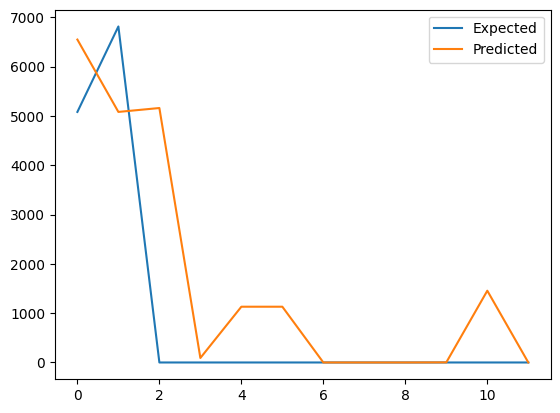

In [105]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # use only first 18 observations in test set for validation
    test = test[:18]
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    
    # make predictions for the rest of the test set using the trained model
    for i in range(18, len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # make a prediction using the trained model
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
        
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions
 
# load the dataset
series = df
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=15)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()